# Analysis for SSFA project: NewEplsar model
# Filtered strongly by < 5% NMP

## Table of contents
1. [Used packages](#imports)
1. [Global settings](#settings)
1. [Load data](#load)
1. [Explore data](#exp)
1. [Model specification](#model)
1. [Inference](#inference)
   1. [NewEplsar](#NewEplsar) 
1. [Summary](#summary)  

## Used packages <a name="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pickle
import arviz as az
import pymc3 as pm

In [2]:
from matplotlib.colors import to_rgb

In [3]:
import scipy.stats as stats 

In [4]:
from IPython.display import display

In [5]:
import matplotlib as mpl

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import plotting_lib

## Global settings <a name="settings"></a>

#### Output

In [8]:
writeOut = True
outPathPlots = "../plots/statistical_model_neweplsar_filter_strong/"
outPathData = "../derived_data/statistical_model_neweplsar_filter_strong/"

#### Plotting

In [9]:
widthMM = 190 
widthInch = widthMM / 25.4
ratio = 0.66666
heigthInch = ratio*widthInch

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

dpi = 300

In [10]:
sizes = [SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE]

#### Computing

In [11]:
numSamples = 1000
numCores = 4
numTune = 1000
numPredSamples = 2000
random_seed=3651456135

## Load data <a name="load"></a>

In [12]:
datafile = "../derived_data/preprocessing/preprocessed_filter_strong.dat"

In [13]:
with open(datafile, "rb") as f:
    x1,x2,_,df,dataZ,dictMeanStd,dictTreatment,dictSoftware = pickle.load(f)    

Show that everything is correct:

In [14]:
display(pd.DataFrame.from_dict({'x1':x1,'x2':x2}))

,x1,x2
0,0,5
1,1,5
2,0,5
3,1,5
4,0,5
...,...,...
225,1,9
226,0,9
227,1,9
228,0,9


x1 indicates the software used, x2 indicates the treatment applied.

In [15]:
for surfaceParam,(mean,std) in dictMeanStd.items():
    print("Surface parameter {} has mean {} and standard deviation {}".format(surfaceParam,mean,std))

Surface parameter epLsar has mean 0.0033908522378621737 and standard deviation 0.001989767613698366
Surface parameter Rsquared has mean 0.9973621855273914 and standard deviation 0.007969957191822462
Surface parameter Asfc has mean 13.800529685456086 and standard deviation 12.970336908999228
Surface parameter Smfc has mean 1.350346875497435 and standard deviation 7.832927757231397
Surface parameter HAsfc9 has mean 0.4835258022408901 and standard deviation 0.8643524891543747
Surface parameter HAsfc81 has mean 1.0354777484507558 and standard deviation 2.586788670504154


In [16]:
for k,v in sorted(dictTreatment.items(), key=lambda x: x[0]):    
    print("Number {} encodes treatment {}".format(k,v))

Number 0 encodes treatment BrushDirt
Number 1 encodes treatment BrushNoDirt
Number 2 encodes treatment Clover
Number 3 encodes treatment Clover+dust
Number 4 encodes treatment Control
Number 5 encodes treatment Dry bamboo
Number 6 encodes treatment Dry grass
Number 7 encodes treatment Dry lucerne
Number 8 encodes treatment Grass
Number 9 encodes treatment Grass+dust
Number 10 encodes treatment RubDirt


In [17]:
for k,v in dictSoftware.items():
    print("Number {} encodes software {}".format(k,v))

Number 0 encodes software ConfoMap
Number 1 encodes software Toothfrax


In [18]:
display(dataZ)

,index,TreatmentNumber,SoftwareNumber,DatasetNumber,NameNumber,epLsar_z,Rsquared_z,Asfc_z,Smfc_z,HAsfc9_z,HAsfc81_z
0,0,5,0,0,98,0.515753,0.080435,-0.165334,-0.134789,-0.402292,-0.259843
1,1,5,1,0,98,0.668494,0.275762,-0.268289,-0.157173,-0.402677,-0.260418
2,2,5,0,0,99,1.243847,-0.146130,0.128490,-0.134789,-0.360528,-0.285754
3,3,5,1,0,99,1.238912,0.264094,-0.046359,-0.157173,-0.363618,-0.299313
4,4,5,0,0,100,0.829617,-0.323025,-0.046215,-0.134789,-0.257176,-0.243567
...,...,...,...,...,...,...,...,...,...,...,...
225,225,9,1,2,52,0.519230,0.250668,-0.923702,0.007447,0.408438,0.029468
226,226,9,0,2,53,0.005954,0.186666,-0.843131,-0.110277,0.178138,0.194629
227,227,9,1,2,53,-0.126574,0.298222,-0.851345,-0.155367,0.546274,0.307811
228,228,9,0,2,54,-1.091196,0.265539,-0.949772,-0.014439,-0.130543,-0.089431


In [19]:
display(df)

,Dataset,Name,Software,Diet,Treatment,Before.after,NMP,NMP_cat,epLsar,Rsquared,Asfc,Smfc,HAsfc9,HAsfc81,NewEplsar,TreatmentNumber,SoftwareNumber,DatasetNumber,NameNumber
0,GuineaPigs,capor_2CC6B1_txP4_#1_1_100xL_1,ConfoMap,Dry bamboo,Dry bamboo,NaN,0.717312,0-5%,0.004417,0.998003,11.656095,0.294557,0.135803,0.363319,0.019460,5,0,0,98
1,GuineaPigs,capor_2CC6B1_txP4_#1_1_100xL_1,Toothfrax,Dry bamboo,Dry bamboo,NaN,0.717312,0-5%,0.004721,0.999560,10.320730,0.119219,0.135471,0.361833,NaN,5,1,0,98
2,GuineaPigs,capor_2CC6B1_txP4_#1_1_100xL_2,ConfoMap,Dry bamboo,Dry bamboo,NaN,1.674215,0-5%,0.005866,0.996198,15.467083,0.294557,0.171903,0.296292,0.020079,5,0,0,99
3,GuineaPigs,capor_2CC6B1_txP4_#1_1_100xL_2,Toothfrax,Dry bamboo,Dry bamboo,NaN,1.674215,0-5%,0.005856,0.999467,13.199232,0.119219,0.169232,0.261217,NaN,5,1,0,99
4,GuineaPigs,capor_2CC6B1_txP4_#1_1_100xL_3,ConfoMap,Dry bamboo,Dry bamboo,NaN,1.760409,0-5%,0.005042,0.994788,13.201101,0.294557,0.261235,0.405422,0.019722,5,0,0,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Sheeps,L8-Ovis-90730-lm2sin-a,Toothfrax,Grass+dust,Grass+dust,NaN,0.000000,0-5%,0.004424,0.999360,1.819802,1.408678,0.836560,1.111706,NaN,9,1,2,52
226,Sheeps,L8-Ovis-90764-lm2sin-a,ConfoMap,Grass+dust,Grass+dust,NaN,0.000000,0-5%,0.003403,0.998850,2.864831,0.486556,0.637499,1.538943,0.018978,9,0,2,53
227,Sheeps,L8-Ovis-90764-lm2sin-a,Toothfrax,Grass+dust,Grass+dust,NaN,0.000000,0-5%,0.003139,0.999739,2.758297,0.133366,0.955699,1.831721,NaN,9,1,2,53
228,Sheeps,L8-Ovis-90814-lm2sin-a,ConfoMap,Grass+dust,Grass+dust,NaN,0.000000,0-5%,0.001220,0.999479,1.481662,1.237247,0.370691,0.804138,0.017498,9,0,2,54


## Exploration <a name="exp"></a>

In [20]:
dfNewAvail = df[~df.NewEplsar.isna()].copy()

We look at the overall relationship between both epLsar variants on ConfoMap. 

In [21]:
yrange = [0.015,0.022]
xrange = [ -0.0005 , 0.0085]

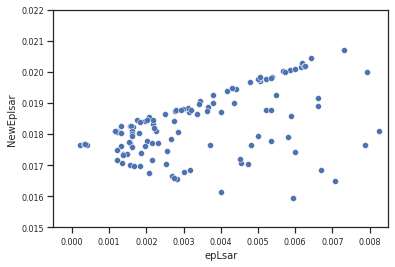

In [22]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar');
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Could be linear, but there is also a lot of noise.

Maybe different treatments have different behavior?

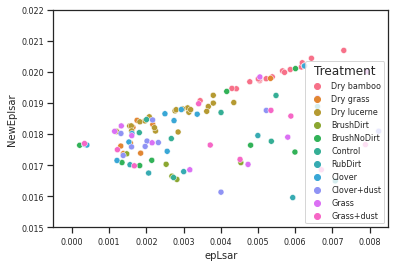

In [23]:
ax = sns.scatterplot(data=dfNewAvail,x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

Too crowded, let's try it per dataset

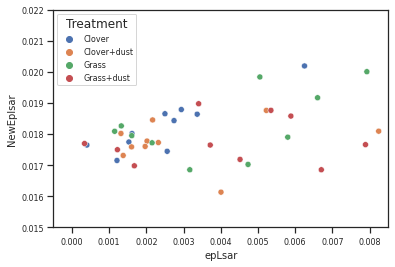

In [24]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Sheeps"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

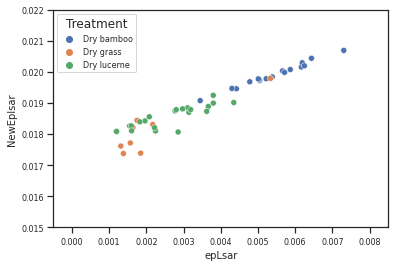

In [25]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "GuineaPigs"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

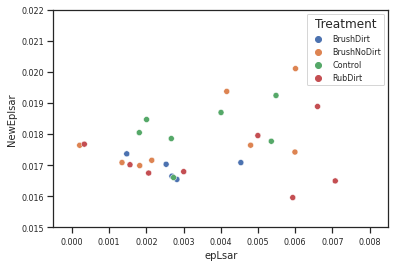

In [26]:
ax = sns.scatterplot(data=dfNewAvail[dfNewAvail.Dataset == "Lithics"],x='epLsar',y='NewEplsar',hue="Treatment");
ax.set_xlim(xrange);
ax.set_ylim(yrange);

### Standardization in z scores

In [27]:
dfNewAvail.NewEplsar

0      0.019460
2      0.020079
4      0.019722
6      0.020694
8      0.020442
         ...   
220    0.018765
222    0.018581
224    0.017697
226    0.018978
228    0.017498
Name: NewEplsar, Length: 115, dtype: float64

In [28]:
mu = dfNewAvail.NewEplsar.mean()
mu

0.018301155106347822

In [29]:
sig = dfNewAvail.NewEplsar.std()
sig

0.0010635804118111583

In [30]:
dictMeanStd['NewEplsar'] = (mu,sig)

In [31]:
newZ = (dfNewAvail.NewEplsar.values-mu) / sig

In [32]:
newIndex = df[~df.NewEplsar.isna()].index.values

## Model specification <a name="model"></a>

In [33]:
class Model_NewEplsar(pm.Model):
    
    """
    Compute params of priors and hyperpriors.
    """
    def getParams(self,x2,y):
        # get lengths        
        Nx2Lvl = np.unique(x2).size
        
        dims = (Nx2Lvl)
        
        ### get standard deviations
        
        # convert to pandas dataframe to use their logic
        df = pd.DataFrame.from_dict({'x2':x2,'y':y})
        
        s2 = df.groupby('x2').std()['y'].max()
        stdSingle = s2
        
        return (dims, stdSingle)
    
    def printParams(self,x2,y):
        dims, stdSingle= self.getParams(x2,y)
        Nx2Lvl = dims
        s2 = stdSingle
                
        print("The number of levels of the x variables are {}".format(dims))
        print("The standard deviations used for the beta prior is {}".format(stdSingle))        
    
    def __init__(self,name,x2,y,model=None):
        
        # call super's init first, passing model and name
        super().__init__(name, model)
        
        # get parameter of hyperpriors
        dims, stdSingle = self.getParams(x2,y)
        Nx2Lvl  = dims
        s2 = stdSingle
                
        ### hyperpriors ### 
        # observation hyperpriors
        lamY = 1/30.
        muGamma = 0.5
        sigmaGamma = 2.
        
        # prediction hyperpriors
        sigma0 = pm.HalfNormal('sigma0',sd=1)         
        sigma2 = pm.HalfNormal('sigma2',sd=s2, shape=Nx2Lvl)
        
        
        mu_b0 = pm.Normal('mu_b0', mu=0., sd=1)              
        mu_b2 = pm.Normal('mu_b2', mu=0., sd=1, shape=Nx2Lvl)       
        beta2 = 1.5*(np.sqrt(6)*sigma2)/(np.pi)
                                       
        ### priors ### 
        # observation priors        
        nuY = pm.Exponential('nuY',lam=lamY)
        sigmaY = pm.Gamma('sigmaY',mu=muGamma, sigma=sigmaGamma)
        
        # prediction priors
        b0_dist = pm.Normal('b0_dist', mu=0, sd=1)
        b0 = pm.Deterministic("b0", mu_b0 + b0_dist * sigma0)
                        
        b2_beta = pm.HalfNormal('b2_beta', sd=beta2, shape=Nx2Lvl)
        b2_dist = pm.Gumbel('b2_dist', mu=0, beta=1)
        b2 = pm.Deterministic("b2", mu_b2 + b2_beta * b2_dist)
        
        #### prediction ###         
        mu = pm.Deterministic('mu',b0 + b2[x2])
                                        
        ### observation ### 
        y = pm.StudentT('y',nu = nuY, mu=mu, sd=sigmaY, observed=y)

## Inference <a name="inference"></a>

### NewEplsar <a name="NewEplsar"></a>

In [34]:
with pm.Model() as model:
    new_epLsarModel = Model_NewEplsar('NewEplsar',x2[newIndex],newZ)

#### Verify model settings

In [35]:
new_epLsarModel.printParams(x2[newIndex],newZ)

The number of levels of the x variables are 11
The standard deviations used for the beta prior is 1.0930239484890847


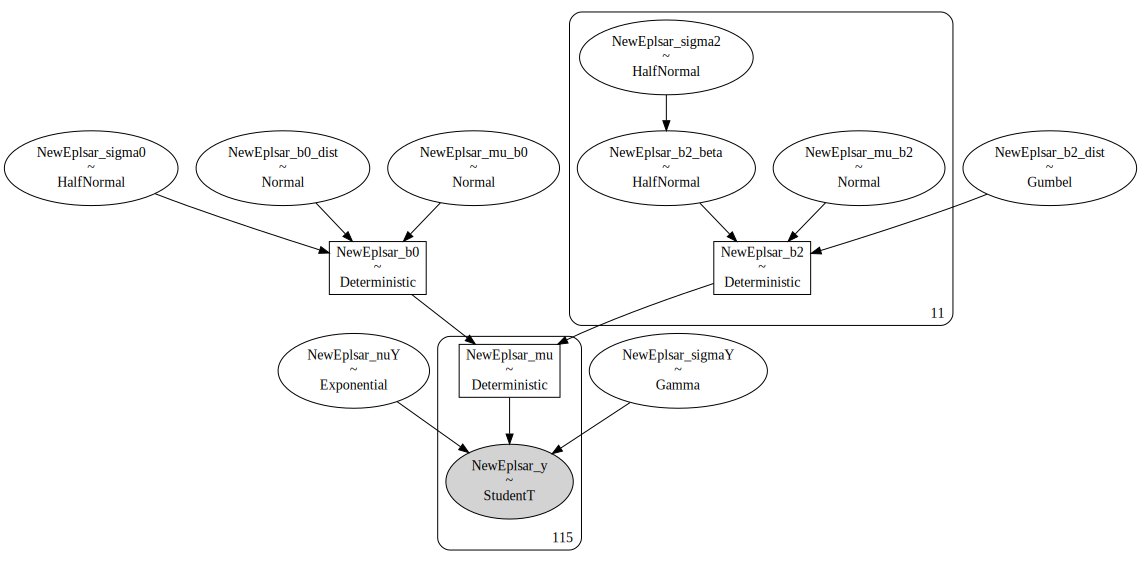

In [36]:
try:
    graph_new_epLsar = pm.model_to_graphviz(new_epLsarModel)    
except:
    graph_new_epLsar = "Could not make graph"
graph_new_epLsar

#### Check prior choice

In [37]:
with new_epLsarModel as model:
    prior_pred_new_epLsar = pm.sample_prior_predictive(samples=numPredSamples,random_seed=random_seed)

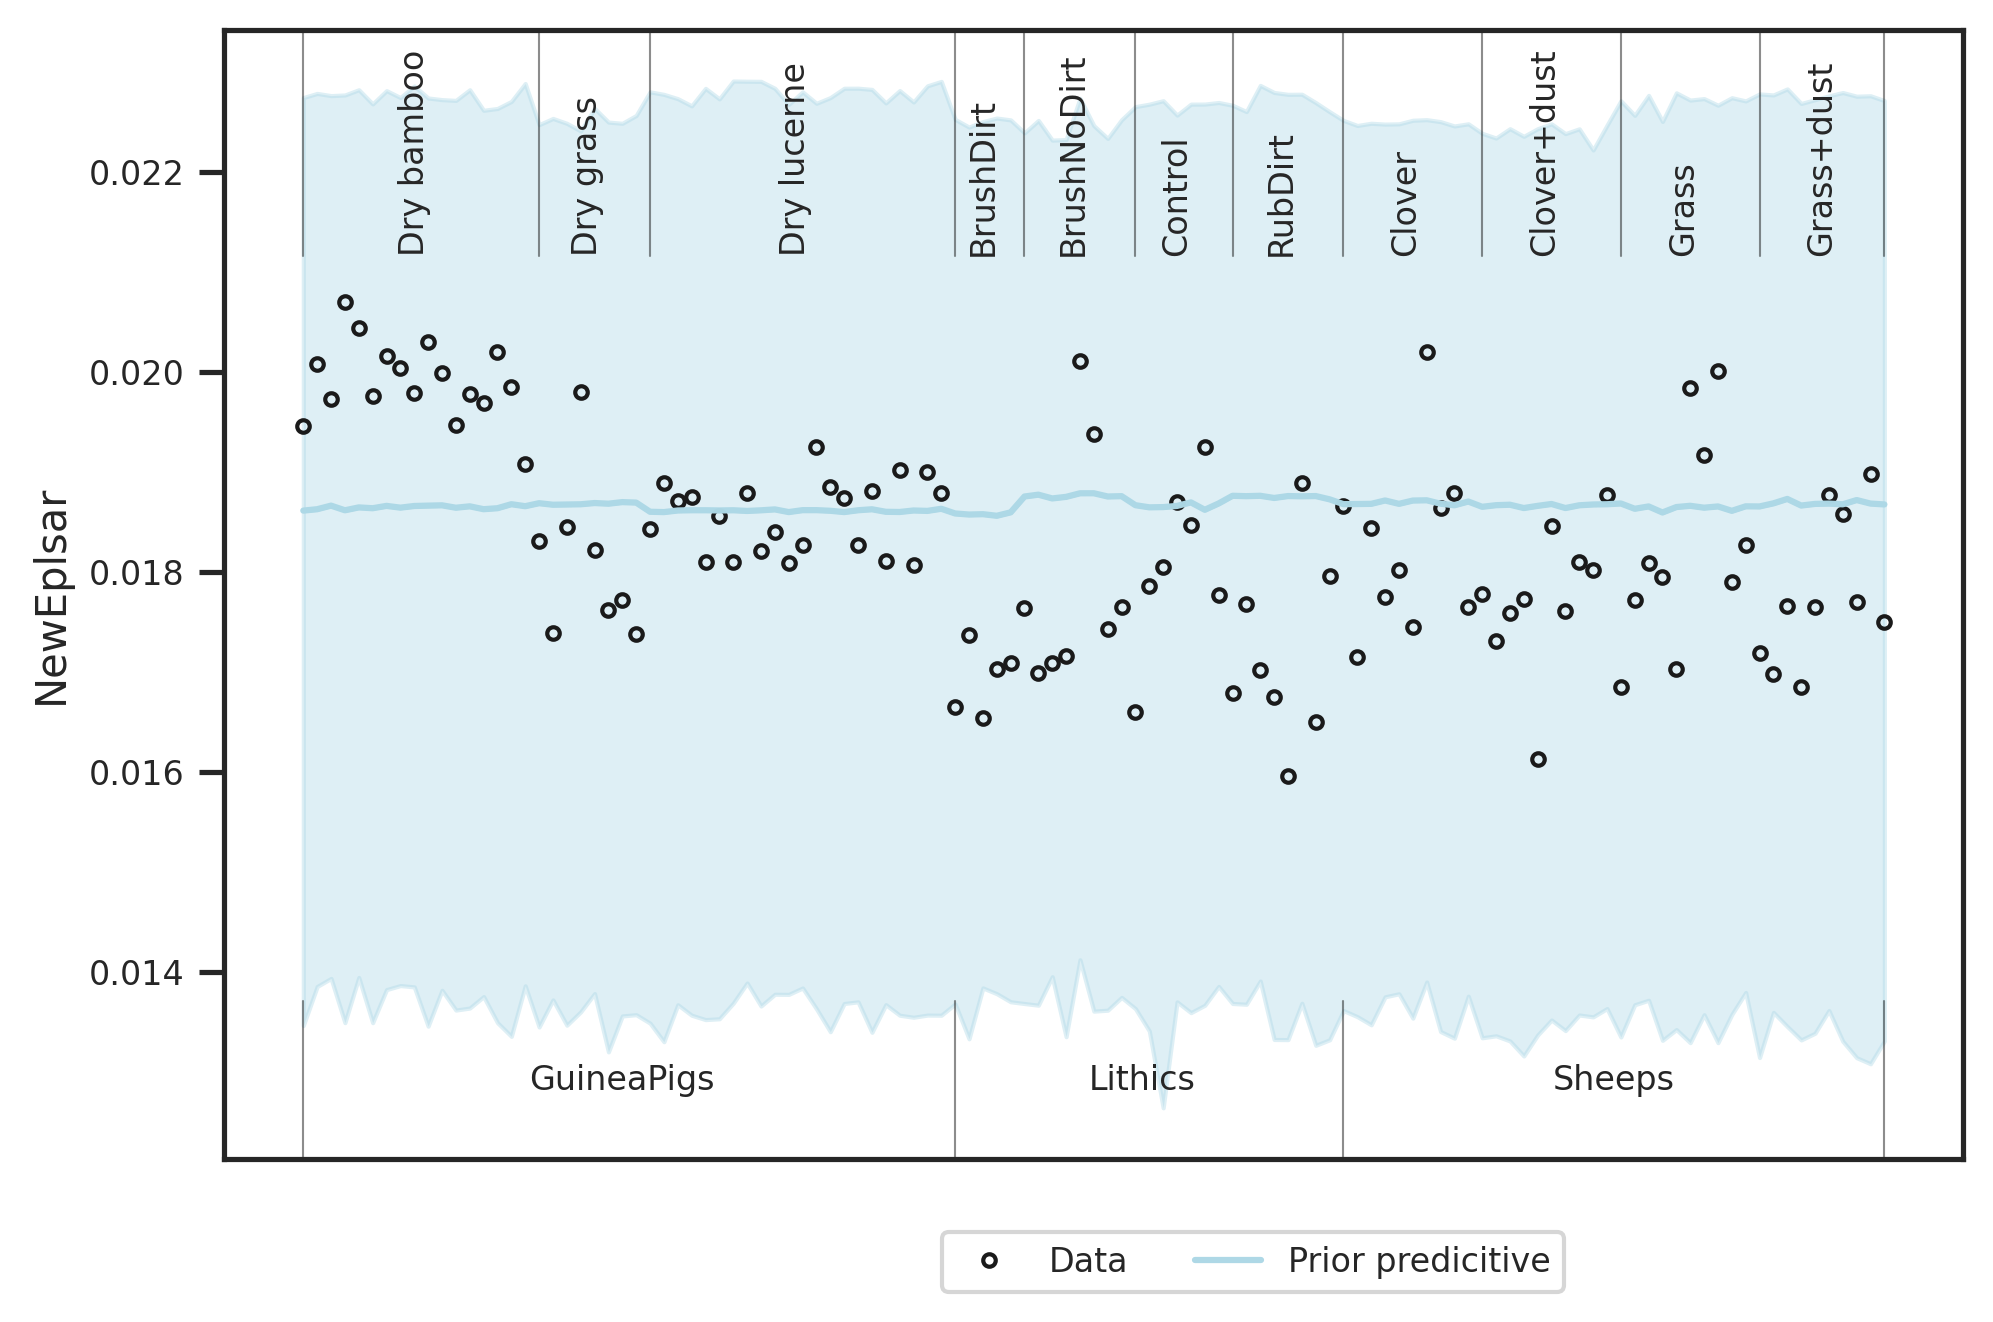

In [38]:
plotting_lib.plotPriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,newZ,'NewEplsar')

Prior choice is as intended: Broad over the data range.

#### Sampling

In [39]:
with new_epLsarModel as model:
    trace_new_epLsar = pm.sample(numSamples,cores=numCores,tune=numTune,max_treedepth=20, init='auto',target_accept=0.99,random_seed=random_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NewEplsar_b2_dist, NewEplsar_b2_beta, NewEplsar_b0_dist, NewEplsar_sigmaY, NewEplsar_nuY, NewEplsar_mu_b2, NewEplsar_mu_b0, NewEplsar_sigma2, NewEplsar_sigma0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [40]:
with new_epLsarModel as model:
    if writeOut:
        with open(outPathData + 'model_{}.pkl'.format('NewEplsar'), 'wb') as buff:
            pickle.dump({'model':new_epLsarModel, 'trace': trace_new_epLsar}, buff)

#### Check sampling

In [41]:
with new_epLsarModel as model:
    dataTrace_new_epLsar = az.from_pymc3(trace=trace_new_epLsar)

In [42]:
pm.summary(dataTrace_new_epLsar,hdi_prob=0.95).round(2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
NewEplsar_mu_b0,-0.19,0.65,-1.43,1.20,0.02,0.01,1733.0,1733.0,1709.0,2342.0,1.0
NewEplsar_mu_b2[0],-0.88,0.48,-1.82,0.08,0.01,0.01,1512.0,1512.0,1586.0,1734.0,1.0
NewEplsar_mu_b2[1],-0.34,0.48,-1.30,0.58,0.01,0.01,2038.0,2038.0,2028.0,2408.0,1.0
NewEplsar_mu_b2[2],0.14,0.48,-0.72,1.14,0.01,0.01,2041.0,2041.0,2044.0,2527.0,1.0
NewEplsar_mu_b2[3],-0.18,0.45,-1.02,0.72,0.01,0.01,1866.0,1866.0,1891.0,2100.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
NewEplsar_mu[110],-0.54,0.22,-0.94,-0.10,0.00,0.00,4753.0,4655.0,4764.0,3355.0,1.0
NewEplsar_mu[111],-0.54,0.22,-0.94,-0.10,0.00,0.00,4753.0,4655.0,4764.0,3355.0,1.0
NewEplsar_mu[112],-0.54,0.22,-0.94,-0.10,0.00,0.00,4753.0,4655.0,4764.0,3355.0,1.0
NewEplsar_mu[113],-0.54,0.22,-0.94,-0.10,0.00,0.00,4753.0,4655.0,4764.0,3355.0,1.0


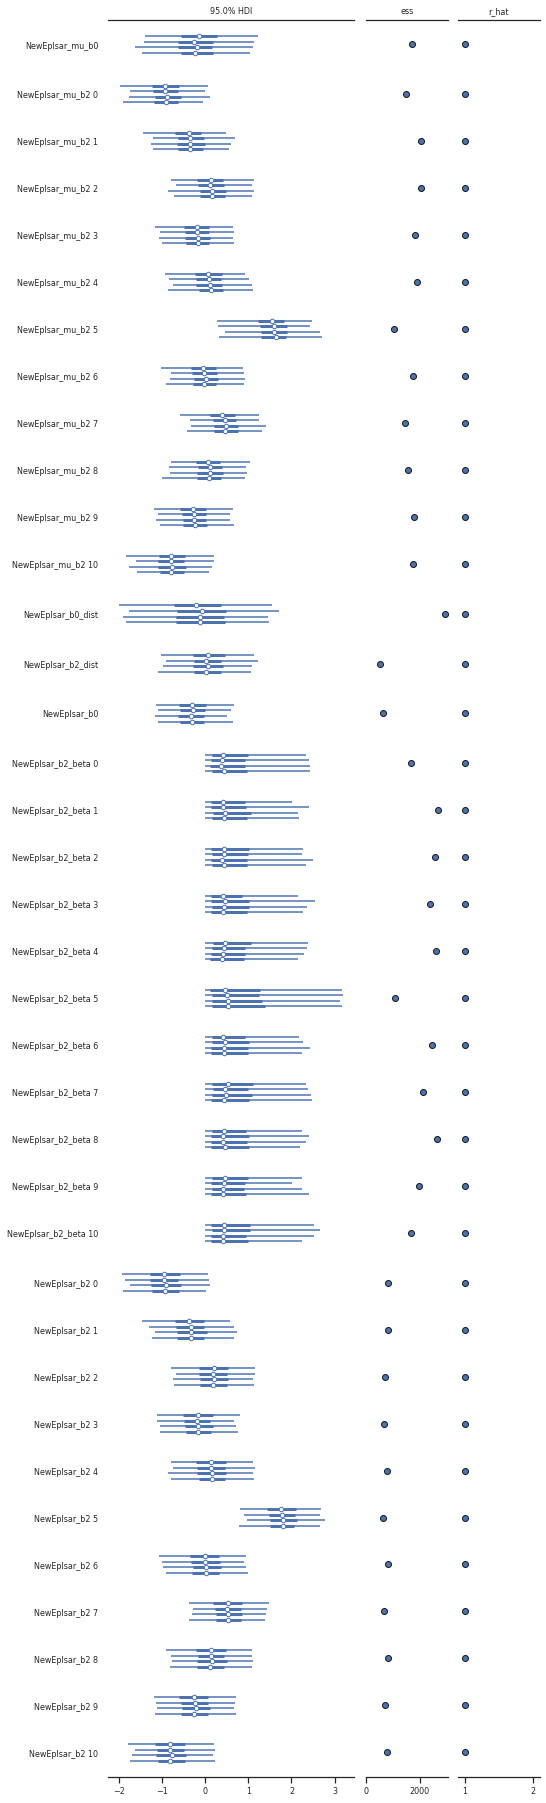

In [43]:
az.plot_forest(dataTrace_new_epLsar,var_names=['b0','b2'],filter_vars='like',figsize=(widthInch,5*heigthInch),hdi_prob=0.95,ess=True,r_hat=True);
if writeOut:
    plt.savefig(outPathPlots + "posterior_forest_{}.pdf".format('NewEplsar'),dpi=dpi)

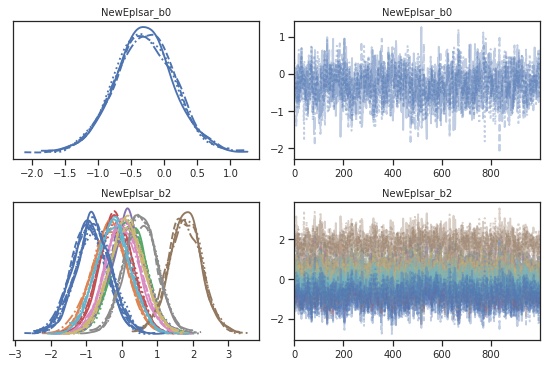

In [44]:
with new_epLsarModel as model:
    plotting_lib.plotTracesB(widthInch,heigthInch,dpi,writeOut,outPathPlots,trace_new_epLsar,'NewEplsar')

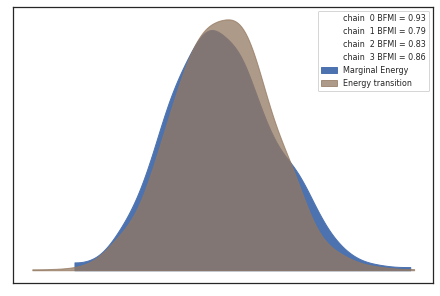

In [45]:
with new_epLsarModel as model:
    plotting_lib.pm.energyplot(trace_new_epLsar)

#### Posterior predictive distribution

In [46]:
with new_epLsarModel as model:
    posterior_pred_new_epLsar = pm.sample_posterior_predictive(trace_new_epLsar,samples=numPredSamples,random_seed=random_seed)

/home/bob/Documents/Projekt_Neuwied/SSFA/ssfa-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


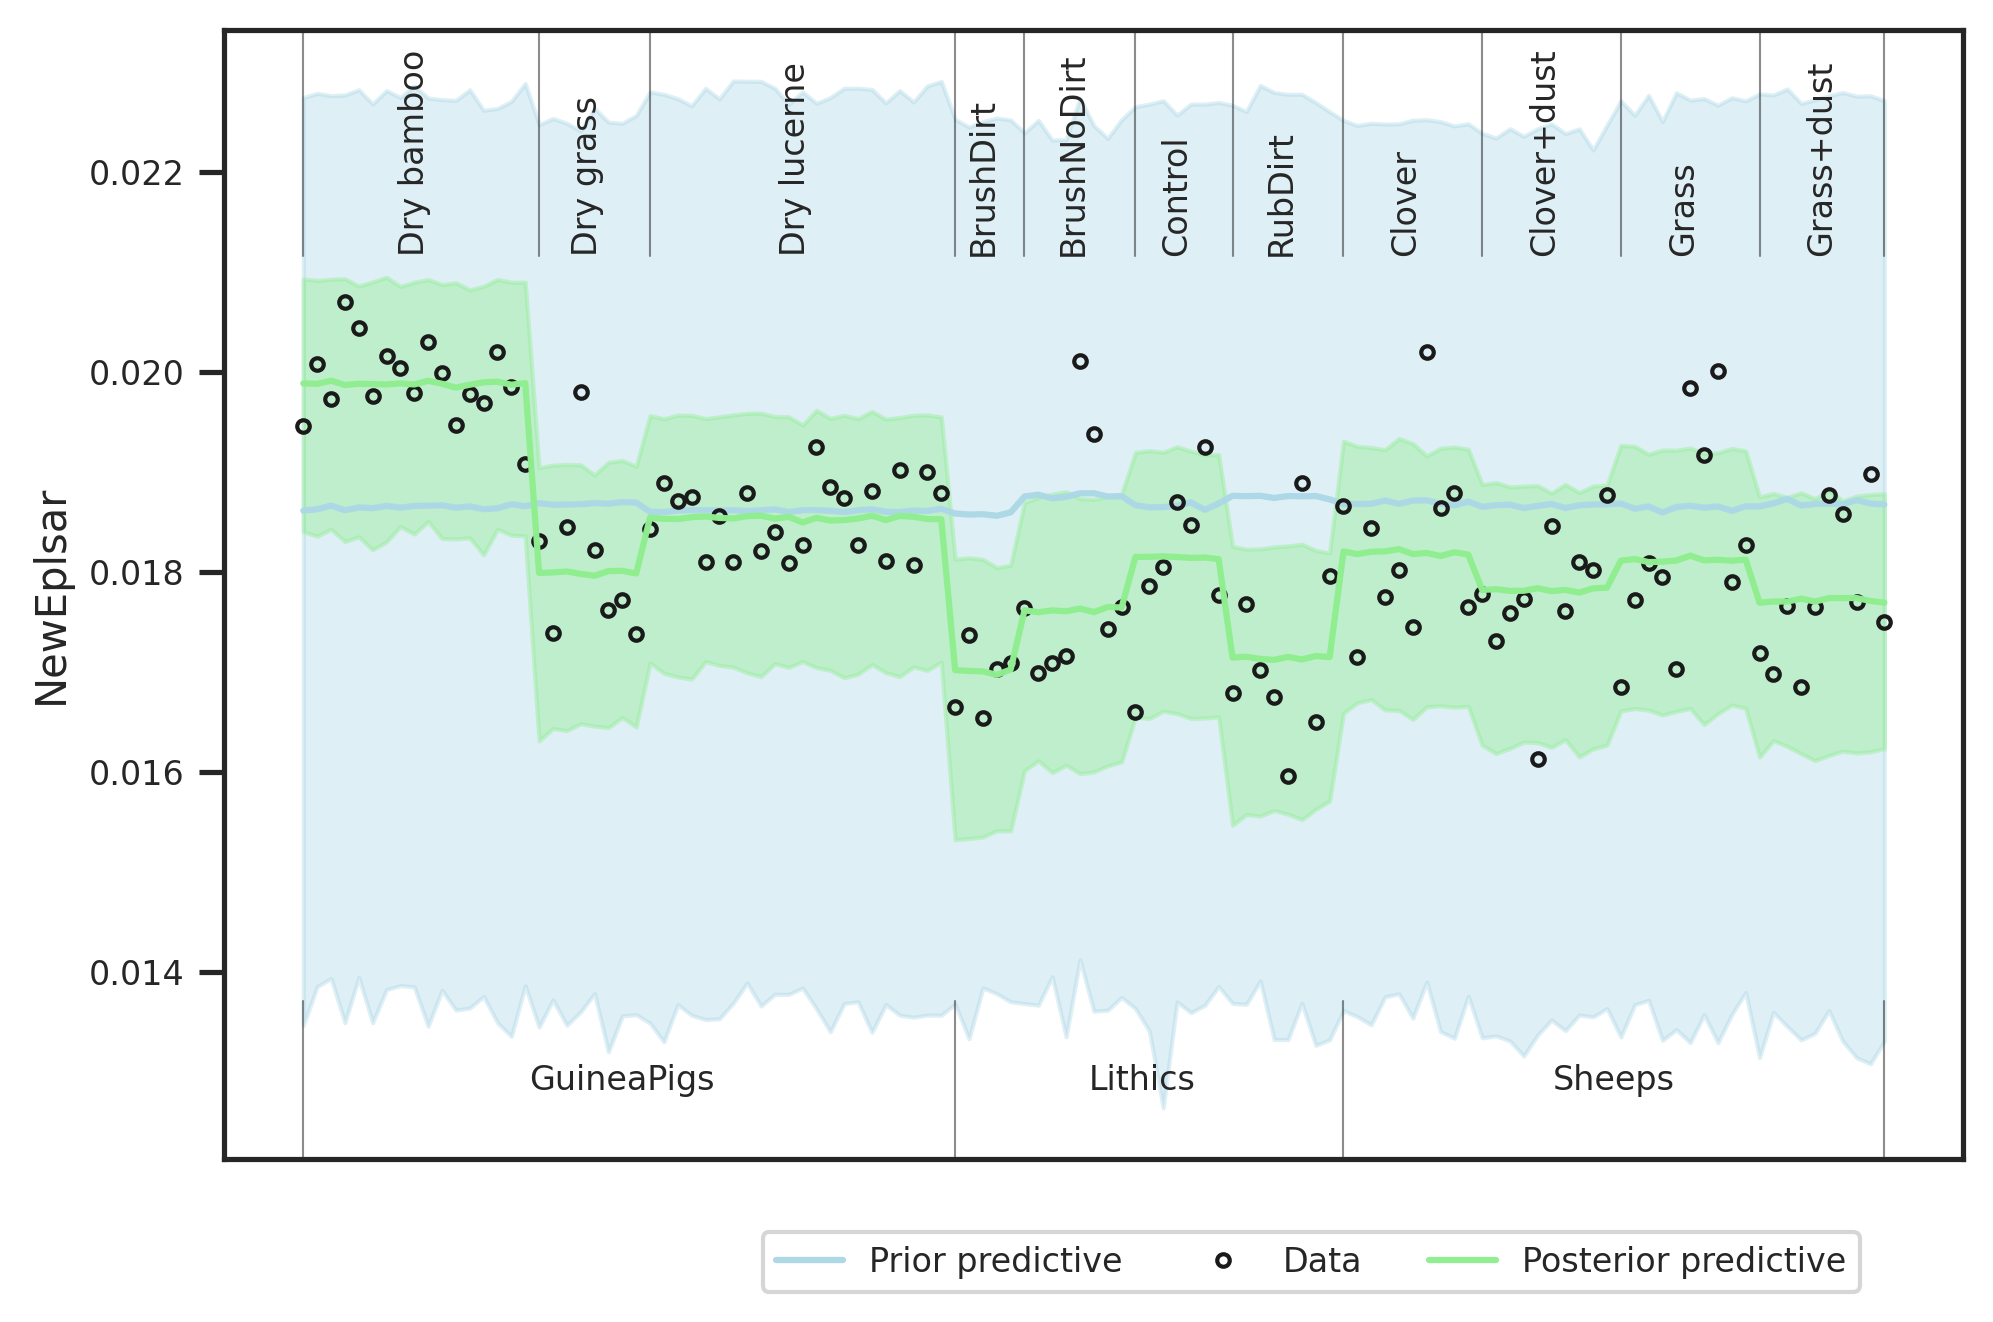

In [47]:
plotting_lib.plotPriorPosteriorPredictive(widthInch,heigthInch,dpi,writeOut,outPathPlots,dfNewAvail.reset_index(),dictMeanStd,prior_pred_new_epLsar,posterior_pred_new_epLsar,newZ,'NewEplsar')

### Posterior check

In [48]:
with new_epLsarModel as model:
    pm_data_new_epLsar = az.from_pymc3(trace=trace_new_epLsar,prior=prior_pred_new_epLsar,posterior_predictive=posterior_pred_new_epLsar)

arviz.data.io_pymc3 - WARNING - posterior predictive variable NewEplsar_y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


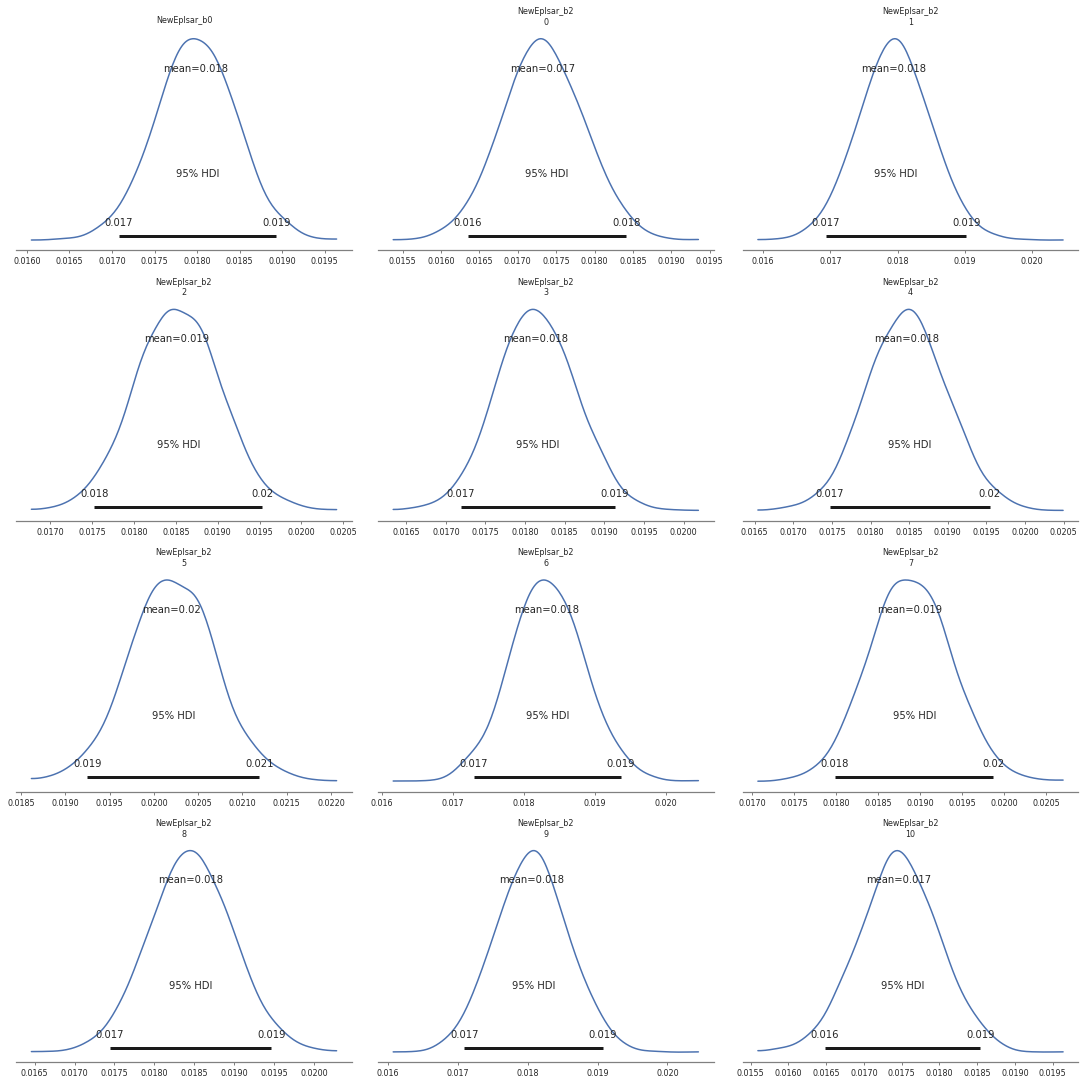

In [49]:
plotting_lib.plotPosterior(widthInch,heigthInch,dpi,writeOut,outPathPlots,dictMeanStd,pm_data_new_epLsar,'NewEplsar')

### Compare treatment differences with other epLsar values

In [50]:
b1P_Old = np.load("../derived_data/statistical_model_two_factors_filter_strong/epLsar_oldb1.npy")
b2P_Old = np.load("../derived_data/statistical_model_two_factors_filter_strong/epLsar_oldb2.npy")
M12P_Old = np.load("../derived_data/statistical_model_two_factors_filter_strong/epLsar_oldM12.npy")

In [51]:
from collections import defaultdict 

In [52]:
def plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,path,dictMeanStd,dictTreatment,dictSoftware,trace,yname,x1,x3):
        
    SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = sizes
    
    mu_Val,sig_Val = dictMeanStd[yname]
    
    # get posterior samples    
    b2P = sig_Val*trace['{}_b2'.format(yname)]
    
    # prepare color dict for treatments
    # use groups of 4 colors, as in tab20c
    colorIndex = dict({5:0,6:1,7:2,0:4,1:5,4:6,10:7,2:8,3:9,8:10,9:11})
    
    # prepare dataset dict for treatments   
    dictDataset = dict({5:0,6:0,7:0,0:1,1:1,4:1,10:1,2:2,3:2,8:2,9:2})
    
    # === inverse dict ==== 
    inv_dictDataset = defaultdict(list)                                                                  
  
    # using loop to perform reverse mapping 
    for keys, vals in dictDataset.items():  
        for val in [vals]:  
            inv_dictDataset[val].append(keys) 
    # === 
    
    # get number of datasets    
    numDatasets = len(np.unique(list(dictDataset.values())))
    
    # get number of treatments per dataset
    dictDataset2NumberTreats = dict()
    for numDataset in range(numDatasets):        
        n = len(inv_dictDataset[numDataset])
        dictDataset2NumberTreats[numDataset] = n      
         
    # Get maximum of treatments per dataset
    tmax = np.max(list(dictDataset2NumberTreats.values()))
    
    
    # compute maximal number of pairs 
    maxpair = int(tmax*(tmax-1)/2)
    
    
    fig = plt.subplots(squeeze=False, figsize=(numDatasets*widthInch,maxpair*heigthInch), dpi=dpi);
    
    # store list for hdi
    hdiList = []

    for indexDataset in np.arange(numDatasets):
        # counter for row
        rowCounter = 0
        
        # first treatment 
        for treatmentNum_i,lvl2_i in enumerate(inv_dictDataset[indexDataset]):
            
            # second treatment 
            for treatmentNum_j,lvl2_j in enumerate(inv_dictDataset[indexDataset]):
                
                if treatmentNum_i > treatmentNum_j:
                                       
                    
                    # set subplot                    
                    curr_ax = plt.subplot2grid((maxpair, numDatasets), (rowCounter,indexDataset))
  
                    # compute difference between treatments for each software
                    diffS0 = sig_Val*((M12P_Old[:,0,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,0,lvl2_j]+b2P_Old[:,lvl2_j]))
                    diffS1 = sig_Val*((M12P_Old[:,1,lvl2_i]+b2P_Old[:,lvl2_i]) -(M12P_Old[:,1,lvl2_j]+b2P_Old[:,lvl2_j]))
                    
                    #plot posterior                    
                    sns.kdeplot(diffS1,ax=curr_ax,label="epLsar on {}".format(dictSoftware[1]),color='gray',alpha=0.3,ls='--');
                    sns.kdeplot(diffS0,ax=curr_ax,label="epLsar on {}".format(dictSoftware[0]),color='gray',alpha=0.3,ls='dotted');                    
                    sns.kdeplot(b2P[:,lvl2_i]-b2P[:,lvl2_j],ax=curr_ax,label="NewEplsar on {}".format(dictSoftware[0]),color='C0',alpha=0.3,ls='dotted');
                                        
                    # plot reference value zero
                    curr_ax.axvline(x=0,color="C1")
                    
                    # get hdi
                    hdi_new = az.hdi(az.convert_to_inference_data(b2P[:,lvl2_i]-b2P[:,lvl2_j]),hdi_prob=0.95)['x'].values
                    hdiS0 = az.hdi(az.convert_to_inference_data(diffS0),hdi_prob=0.95)['x'].values
                    hdiS1 = az.hdi(az.convert_to_inference_data(diffS1),hdi_prob=0.95)['x'].values  
                    
                    isSignificant = lambda x: (x[0] > 0.0) or (x[1] < 0.0)
                    
                    # store hdi
                    hdiList.append([dictTreatment[lvl2_i],dictTreatment[lvl2_j],
                                    hdi_new[0],hdi_new[1],isSignificant(hdi_new),                                 
                                   hdiS0[0],hdiS0[1],isSignificant(hdiS0),
                                    hdiS1[0],hdiS1[1],isSignificant(hdiS1)
                                   ])
                    
                    # set title 
                    nameFirst = dictTreatment[lvl2_i]
                    nameSecond = dictTreatment[lvl2_j]
                    title = "{} vs. {}".format(nameFirst,nameSecond)
                    if isSignificant(hdi_new):
                        title += ": Significant on NewEplsar"

                            
                    curr_ax.set_title(title)
                    
                    # add legend
                    curr_ax.legend()   
                    
                    # set x label
                    curr_ax.set_xlabel('Delta')
                    
                    # remove y label decoration
                    curr_ax.tick_params(left=False)
                    curr_ax.set(yticklabels=[])
                    
                    
                    # increment counter
                    rowCounter += 1
                    
    #plt.suptitle('Estimated differences between treatments on {}'.format(yname))
    
    plt.tight_layout()                
    
    if writeOut:
        plt.savefig(path + "treatment_pairs_{}.pdf".format(yname),dpi=dpi)
    
    plt.show()
    
    # convert hdi to df
    df = pd.DataFrame(hdiList,columns=["Treatment_i","Treatment_j",
                                       "hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","isSignificant_NewEplsar","hdi_{}_2.5%".format(dictSoftware[0]),"hdi_{}_97.5%".format(dictSoftware[0]),"isSignificant_on_{}".format(dictSoftware[0]),
                                  "hdi_{}_2.5%".format(dictSoftware[1]),"hdi_{}_97.5%".format(dictSoftware[1]),"isSignificant_on_{}".format(dictSoftware[1])])
    return df

In [53]:
dfHDI = plotTreatmentPosterior(widthInch,heigthInch,dpi,sizes,writeOut,outPathPlots,dictMeanStd,dictTreatment,dictSoftware,trace_new_epLsar,'NewEplsar',x1[newIndex],x2[newIndex])

In [54]:
dfHDI

,Treatment_i,Treatment_j,hdi_NewEplsar_2.5%,hdi_NewEplsar_97.5%,isSignificant_NewEplsar,hdi_ConfoMap_2.5%,hdi_ConfoMap_97.5%,isSignificant_on_ConfoMap,hdi_Toothfrax_2.5%,hdi_Toothfrax_97.5%,isSignificant_on_Toothfrax
0,Dry grass,Dry bamboo,-0.002432,-0.001317,True,-0.002483,-0.001163,True,-0.002425,-0.001073,True
1,Dry lucerne,Dry bamboo,-0.001744,-0.000967,True,-0.001994,-0.000989,True,-0.002125,-0.001123,True
2,Dry lucerne,Dry grass,-0.000005,0.001062,False,-0.000298,0.000995,False,-0.000566,0.000752,False
3,BrushNoDirt,BrushDirt,-0.000096,0.001424,False,-0.000767,0.001198,False,-0.001081,0.000761,False
4,Control,BrushDirt,0.000360,0.001854,True,-0.000681,0.001184,False,-0.000577,0.001413,False
5,Control,BrushNoDirt,-0.000262,0.001256,False,-0.000922,0.000975,False,-0.000236,0.001565,False
6,RubDirt,BrushDirt,-0.000588,0.000882,False,-0.000482,0.001530,False,-0.000985,0.001008,False
7,RubDirt,BrushNoDirt,-0.001186,0.000246,False,-0.000851,0.001292,False,-0.000745,0.001051,False
8,RubDirt,Control,-0.001777,-0.000251,True,-0.000658,0.001312,False,-0.001443,0.000513,False
9,Clover+dust,Clover,-0.000999,0.000210,False,-0.000614,0.000871,False,-0.000503,0.000937,False


In [55]:
if writeOut:
    dfHDI.to_csv(outPathData+ 'hdi_{}_filter_strong.csv'.format('NewEplsar'))

## Summary<a name="summary"></a>

Show where NewEplsar yields other results then epLsar: 

In [56]:
df_summary = dfHDI[(dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_ConfoMap) | (dfHDI.isSignificant_NewEplsar != dfHDI.isSignificant_on_Toothfrax) ][["Treatment_i","Treatment_j","isSignificant_NewEplsar","isSignificant_on_Toothfrax","isSignificant_on_ConfoMap","hdi_NewEplsar_2.5%","hdi_NewEplsar_97.5%","hdi_ConfoMap_2.5%","hdi_ConfoMap_97.5%","hdi_Toothfrax_2.5%","hdi_Toothfrax_97.5%"]]
df_summary

,Treatment_i,Treatment_j,isSignificant_NewEplsar,isSignificant_on_Toothfrax,isSignificant_on_ConfoMap,hdi_NewEplsar_2.5%,hdi_NewEplsar_97.5%,hdi_ConfoMap_2.5%,hdi_ConfoMap_97.5%,hdi_Toothfrax_2.5%,hdi_Toothfrax_97.5%
4,Control,BrushDirt,True,False,False,0.000360,0.001854,-0.000681,0.001184,-0.000577,0.001413
8,RubDirt,Control,True,False,False,-0.001777,-0.000251,-0.000658,0.001312,-0.001443,0.000513
10,Grass,Clover,False,True,False,-0.000745,0.000590,-0.000027,0.001613,0.000206,0.002019
12,Grass+dust,Clover,False,True,True,-0.001116,0.000149,0.000111,0.001722,0.000299,0.001861
13,Grass+dust,Clover+dust,False,True,False,-0.000669,0.000521,-0.000007,0.001696,0.000105,0.001703


In [57]:
if writeOut:
    df_summary.to_csv(outPathData+ 'summary_filter_strong.csv')

### Write out

In [58]:
!jupyter nbconvert --to html Statistical_Model_NewEplsar_filter_strong.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar_filter_strong.ipynb to html
[NbConvertApp] Writing 1076733 bytes to Statistical_Model_NewEplsar_filter_strong.html


In [59]:
!jupyter nbconvert --to markdown Statistical_Model_NewEplsar_filter_strong.ipynb

[NbConvertApp] Converting notebook Statistical_Model_NewEplsar_filter_strong.ipynb to markdown
[NbConvertApp] Support files will be in Statistical_Model_NewEplsar_filter_strong_files/
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Making directory Statistical_Model_NewEplsar_filter_strong_files
[NbConvertApp] Writing 31345 bytes to Statistical_Model_NewEplsar_filter_strong.md
